# IMPLEMENTACJA propagacji wstecznej

## Importy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

## Funkcje do wizualizacji

In [2]:
def bias_to_color(bias, vmin, vmax):
    """Funkcja pomocniczna do liczenia koloru node"""

    if vmin < 0 and vmax > 0:
        # Przypadek 1: mamy biasy ujemne i dodatnie, wówczas używamy red yellow green color mapy
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = plt.get_cmap("RdYlGn") 
    elif vmin >= 0:
        # Przypadek 2: Wszystkie biasy >= 0, wówczas używamy yellow green color mapy
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap("YlGn")
    else:
        # Przypadek 3: Wszystkie biasy <= 0, wówczas używamy yellow orange red mapy (reversed, bo jest od yellow do red, a chcemy, żeby vmax był yellow dla ujemnych)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap("YlOrRd_r")

    return cmap(norm(bias))

def draw_network_networkx(mlp):
    """Wizualizuje stan wag i biasów w sieci:
        - kolor neuronu zależy od wartości biasu (w danej wartwie)
        - kolor krawędzi zależy od znaku odpowiadającej wagi
        - grubość krawędzi zależy od wartości odpowiadającej wagi (tylko dana warstwa)
    """
    G = nx.DiGraph()

    # Zczytaj ilość neuronów
    layers_sizes = []
    input_size = mlp.layers[0].weights.shape[0]
    layers_sizes.append(input_size)
    for layer in mlp.layers:
        layers_sizes.append(layer.weights.shape[1])
    n_layers = len(layers_sizes)

    # Ustal pozycje
    pos = {}
    node_colors = {}
    h_spacing = 2.0  # Odległość horyzontalna między warstwami
    v_spacing = 1.5  # Odległość wertykalna między neuronami tej samej warstwy

    # Ustalamy pozycje i color neuronów
    for i, n_neurons in enumerate(layers_sizes): # dla i-tej warstwy
        x = i * h_spacing
        # Neurony oddzielamy równomiernie w warstwie
        if n_neurons > 1:
            y_positions = np.linspace(0, (n_neurons - 1) * v_spacing, n_neurons)
            y_positions = y_positions - np.max(y_positions) / 2
        else:
            y_positions = np.array([0])
        
        for j, y in enumerate(y_positions): # dla j-tego neuronu w i-tej warstwie
            node_id = (i, j)
            pos[node_id] = (x, y) # ustalamy pozycje neuronu
            if i == 0:
                # Dla input layer ustawiamy kolor neutralny
                node_colors[node_id] = 'lightblue'
            else: # Dla innej niż input layer
                bias = mlp.layers[i-1].biases[j]
                biases_layer = mlp.layers[i-1].biases
                # Normalizujemy kolor funkcją pomociczą
                if len(biases_layer) > 1: # Jeśli mamy > jeden neuron w wartstwie
                    vmin, vmax = np.min(biases_layer), np.max(biases_layer)
                    node_colors[node_id] = bias_to_color(bias, vmin, vmax)
                else: # Jeśli jest jeden nauron
                    node_colors[node_id] = "red" if bias < 0 else "green"
                    
            G.add_node(node_id)

    # Ustalamy grubość połączeń między neuronami na podstawie wag
    for i, layer in enumerate(mlp.layers): # DLa i-tej wastwy
        weights = layer.weights  # połączenie i-tej oraz (i+1)-tej warstwy
        max_weight = np.max(np.abs(weights))
        # Unkamy dzielenia przez 0
        if max_weight == 0:
            max_weight = 1
        for j in range(weights.shape[0]): # DLa j-tego neuronu z i-tej warstwy
            for k in range(weights.shape[1]): # Dla k-tego neurony z (i+1)-tej warstwy
                source = (i, j) # Od j tego neuronu z i-tej warstwy
                target = (i+1, k) # Do k-tego z i+1
                weight = weights[j, k]
                # Skalujemy grubość połączenia (w danej warstwie)
                lw = 0.5 + 5 * (abs(weight) / max_weight)
                color = "red" if weight < 0 else "green"
                G.add_edge(source, target, weight=weight, width=lw, color = color)

    # Rysujemy graf
    fig, ax = plt.subplots(figsize=(12, 8))
    # Rysujemy neurony z kolorami
    node_color_list = [node_colors[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_color_list, node_size=800, ax=ax)
    
    # Rysujemy połączenia z grubością i kolorami
    edge_widths = [d['width'] for (_, _, d) in G.edges(data=True)]
    edge_colors = [d['color'] for (_, _, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors)
    
    # Labelujemy neurony za pomocą indexu w warstwie
    labels = {node: f"{node[1]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, ax=ax)

    ax.set_title("Neural Net Visualization")
    ax.axis('off')
    plt.show()

def show_loss(epoch_arr, loss_arr):
    plt.figure(figsize = (12, 8))
    plt.plot(epoch_arr, loss_arr)
    plt.title("Loss vs epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def eval_2d(network, x, y):
    y_pred = network.predict(x)
    plt.scatter(x, y, s = 1, label = "True")
    plt.scatter(x, y_pred, s=1, label = "Predicted")
    plt.title(f"How fun is fitting desired y")
    plt.legend()
    plt.show()

## Definicja sieci neuronowej

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(output):
    # Zakłada, że wejściem jest "a", a nie "z" (czyli, że jest to już po zastosowaniu sigmoid(a))
    return output * (1 - output)
def linear(x):
    return x
def linear_deriv(x):
    return 1.0
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

class Layer: # Warstwa sieci
    def __init__(self, input_size, output_size, act_fun, act_derivative):
        self.weights = np.random.random((input_size, output_size))
        self.biases = np.random.random(output_size)
        self.act_fun = act_fun
        self.act_derivative = act_derivative
        self.a_in = None
        self.z = None
        self.a_out = None

    def forward(self, x):
        self.a_in = x
        z = np.dot(x, self.weights) + self.biases
        self.z = z
        z = self.act_fun(z)
        self.a_out = z
        return z

    def backward(self, dA):
        # dC / dz
        dZ = self.act_derivative(self.a_out) * dA # zakładamy, że używamy act_derivative na "a", a nie na "z". W przypadku ostatniej warstwy nie ma to znaczenia, o ile zakładamy, że wyjście jest funkcją liniową, a zatem ma stałą pochodną
        # Zmiana na wagach (L)
        dW = np.dot(self.a_in.T, dZ)
        # Zmiana na bias (L)
        db = np.sum(dZ, axis=0)
        # Zmiana dA (L-1)
        dA_in = np.dot(dZ, self.weights.T)
        return dA_in, dW, db

    def update_params(self, dW, db, lr):
        self.weights -= dW * lr
        self.biases -= db * lr
    
    def show_params(self):
        print("Weights")
        print(self.weights)
        print("Biases")
        print(self.biases)

class MLP: # Cała sieć
    def __init__(self, neural_arr, act_fun, act_derivative, out_fun, out_derivative):
        self.layers = []
        for i in range(len(neural_arr) - 2):
            self.layers.append(Layer(neural_arr[i], neural_arr[i+1], act_fun, act_derivative))
        self.layers.append(Layer(neural_arr[-2], neural_arr[-1], out_fun, out_derivative))

        # Do standaryzacji potem
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None

    def standarize_input(self, x):
        return (x - self.input_mean) / self.input_std
    def standarize_output(self, y):
        return (y - self.output_mean) / self.output_std
    def destandarize_output(self, y_std):
        return y_std * self.output_std + self.output_mean

    def forward(self, x):
        z = x.copy()
        for i in range(len(self.layers)):
            z = self.layers[i].forward(z)
        return z

    def predict(self, x):
        x_std = self.standarize_input(x)
        y_std = self.forward(x_std)
        return self.destandarize_output(y_std)

    def backward(self, dA, lr):
        for layer in reversed(self.layers):
            dA, dW, db = layer.backward(dA)
            layer.update_params(dW, db, lr)

    def train(self, x, y, epochs = 100, lr = 0.05):
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        # Trenujemy (for now batch)
        for epoch in range(epochs):
            # Forward
            y_pred_std = self.forward(x_std)
            loss = mse(y_std, y_pred_std)
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
            # Backward
            dA = y_pred_std - y_std
            self.backward(dA, lr)
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")

    def train_visualize(self, x, y, epochs = 100, lr = 0.05):
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        # Trenujemy (for now batch)
        for epoch in range(epochs):
            # Forward
            y_pred_std = self.forward(x_std)
            loss = mse(y_std, y_pred_std)
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
                if epoch % int(epochs / 4) == 0:
                    draw_network_networkx(self)
            # Backward
            dA = y_pred_std - y_std
            self.backward(dA, lr)
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")

    def show_params(self):
        for i in range(len(self.layers)):
            print("Layer: ", i)
            self.layers[i].show_params()
            print("")

## Testy

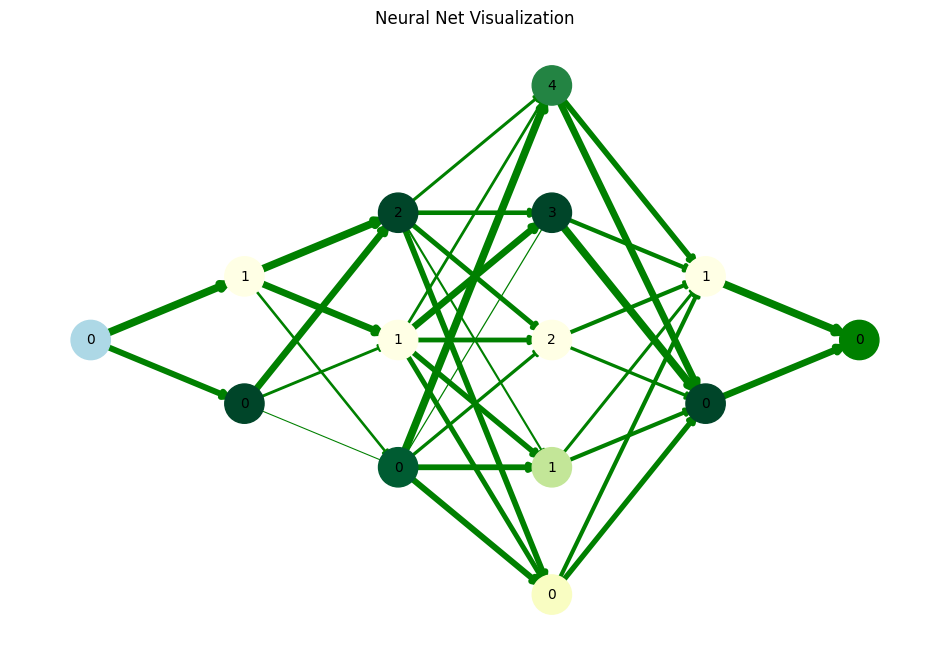

In [4]:
net = MLP([1, 2, 3, 5, 2, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
draw_network_networkx(net)

Wizualizacja sieci działa

In [5]:
a = np.arange(100)
np.random.shuffle(a)
n = 10
len(np.array_split(a, len(a) // n + (len(a) % n != 0)))

10

## Content

### Dane: square-simple

In [6]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/square-simple-training.csv", index_col = 0).to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/square-simple-test.csv", index_col = 0).to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

Epoch: 1, Loss (standarized): 8.514907379876009


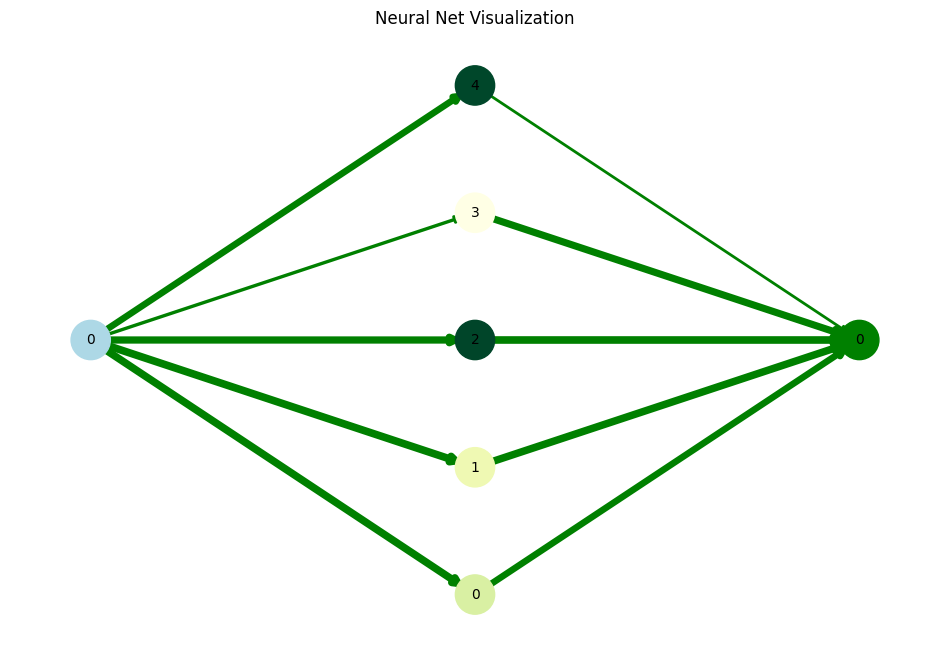

Epoch: 6, Loss (standarized): 67086915.674776986
Epoch: 11, Loss (standarized): 9583500093374116.0
Epoch: 16, Loss (standarized): 1.2841233365703843e+24
Epoch: 21, Loss (standarized): 1.7206372697451664e+32
Epoch: 26, Loss (standarized): 2.305536025802011e+40


C:\Users\barto\AppData\Local\Temp\ipykernel_28896\1571813731.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


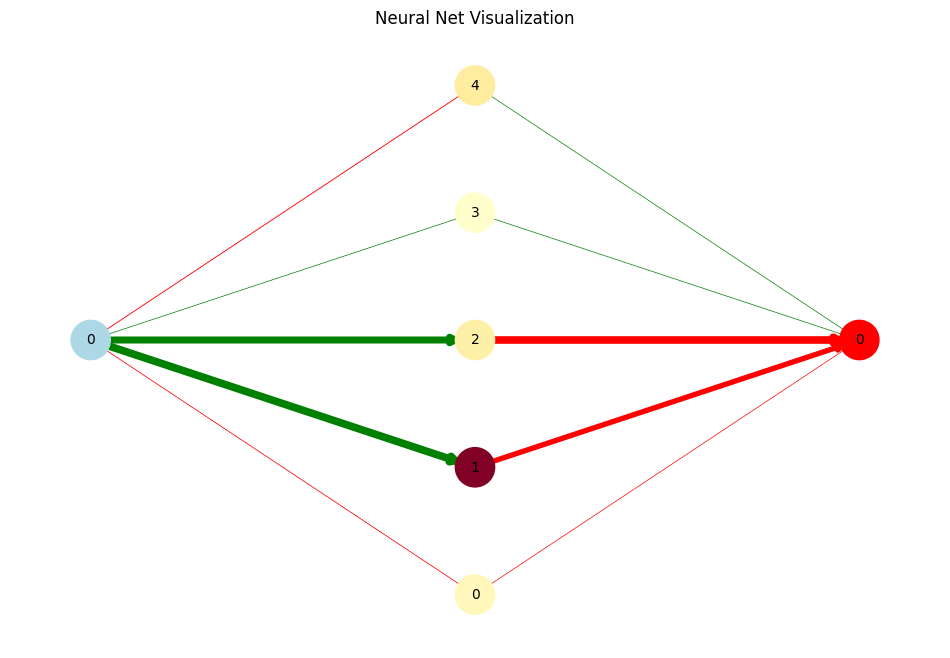

Epoch: 31, Loss (standarized): 3.089260275675757e+48
Epoch: 36, Loss (standarized): 2.9571172460233613e+55
Epoch: 41, Loss (standarized): 5.0581259089277997e+61
Epoch: 46, Loss (standarized): 1.9827564326553765e+68
Epoch: 51, Loss (standarized): 1.081904719964017e+75


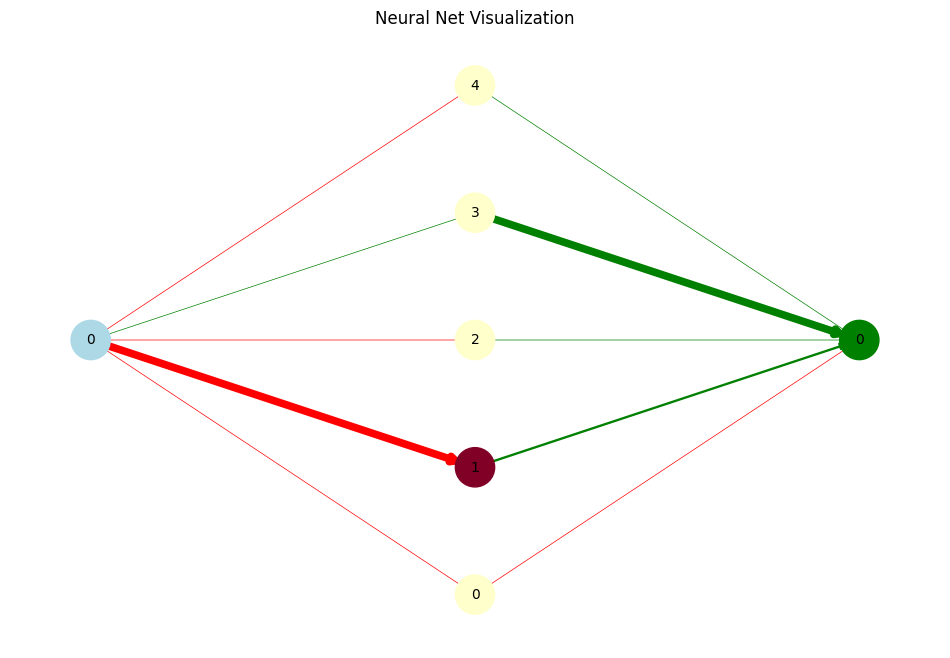

Epoch: 56, Loss (standarized): 5.903487709620723e+81
Epoch: 61, Loss (standarized): 3.2212787775620425e+88
Epoch: 66, Loss (standarized): 1.7577129780182518e+95
Epoch: 71, Loss (standarized): 9.591082071549436e+101
Epoch: 76, Loss (standarized): 5.233440069772393e+108


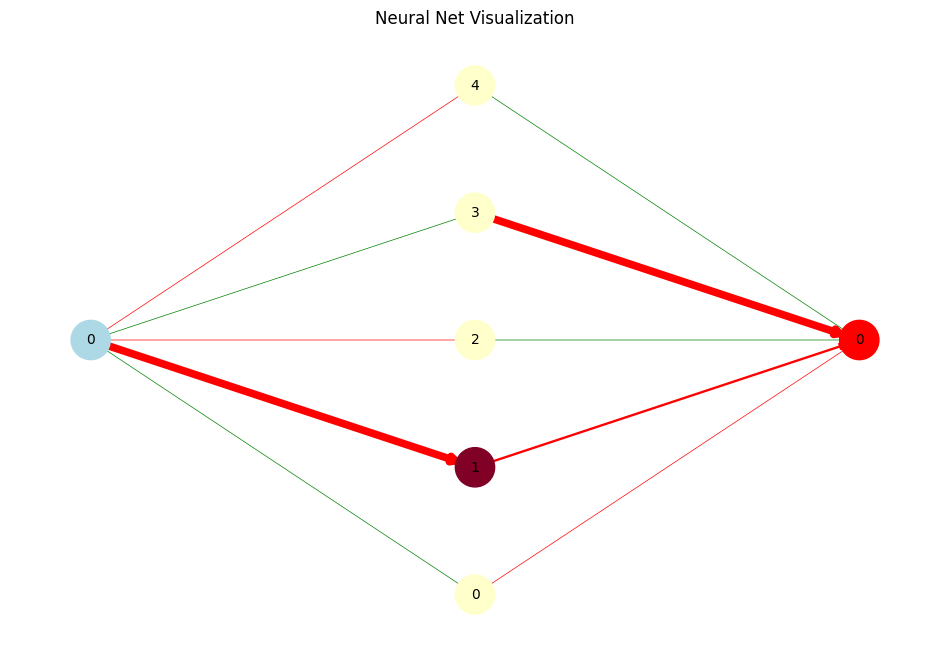

Epoch: 81, Loss (standarized): 2.8556626624168406e+115
Epoch: 86, Loss (standarized): 1.5582120236023475e+122
Epoch: 91, Loss (standarized): 8.502491356748712e+128
Epoch: 96, Loss (standarized): 4.6394430396229206e+135
Final epoch: 100, Final loss (standarized): 1.137631386481167e+141


In [7]:
net = MLP([1, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train_visualize(x = x_train, y = y_train, epochs = 100, lr = 0.05)

Czemu tak się stało? Wygląda jakby eksplodował gradient.

### Zmiany w sieci

Zmiany:
- podzielenie dA przez N zanim wpuścimy do sieci
- dodanie możliwości ustawienia wielkości batcha

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(output):
    # Zakłada, że wejściem jest "a", a nie "z" (czyli, że jest to już po zastosowaniu sigmoid(a))
    return output * (1 - output)
def linear(x):
    return x
def linear_deriv(x):
    return 1.0
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

class Layer: # Warstwa sieci
    def __init__(self, input_size, output_size, act_fun, act_derivative):
        self.weights = np.random.random((input_size, output_size))
        self.biases = np.random.random(output_size)
        self.act_fun = act_fun
        self.act_derivative = act_derivative
        self.a_in = None
        self.z = None
        self.a_out = None

    def forward(self, x):
        self.a_in = x
        z = np.dot(x, self.weights) + self.biases
        self.z = z
        z = self.act_fun(z)
        self.a_out = z
        return z

    def backward(self, dA):
        # dC / dz
        dZ = self.act_derivative(self.a_out) * dA # zakładamy, że używamy act_derivative na "a", a nie na "z". W przypadku ostatniej warstwy nie ma to znaczenia, o ile zakładamy, że wyjście jest funkcją liniową, a zatem ma stałą pochodną
        # Zmiana na wagach (L)
        dW = np.dot(self.a_in.T, dZ)
        # Zmiana na bias (L)
        db = np.sum(dZ, axis=0)
        # Zmiana dA (L-1)
        dA_in = np.dot(dZ, self.weights.T)
        return dA_in, dW, db

    def update_params(self, dW, db, lr):
        self.weights -= dW * lr
        self.biases -= db * lr
    
    def show_params(self):
        print("Weights")
        print(self.weights)
        print("Biases")
        print(self.biases)

class MLP: # Cała sieć
    def __init__(self, neural_arr, act_fun, act_derivative, out_fun, out_derivative):
        self.layers = []
        for i in range(len(neural_arr) - 2):
            self.layers.append(Layer(neural_arr[i], neural_arr[i+1], act_fun, act_derivative))
        self.layers.append(Layer(neural_arr[-2], neural_arr[-1], out_fun, out_derivative))

        # Do standaryzacji potem
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None

    def standarize_input(self, x):
        return (x - self.input_mean) / self.input_std
    def standarize_output(self, y):
        return (y - self.output_mean) / self.output_std
    def destandarize_output(self, y_std):
        return y_std * self.output_std + self.output_mean

    def forward(self, x):
        z = x.copy()
        for i in range(len(self.layers)):
            z = self.layers[i].forward(z)
        return z
        
    def predict(self, x):
        x_std = self.standarize_input(x)
        y_std = self.forward(x_std)
        return self.destandarize_output(y_std)

    def backward(self, dA, lr):
        for layer in reversed(self.layers):
            dA, dW, db = layer.backward(dA)
            layer.update_params(dW, db, lr)

    def train(self, x, y, epochs = 100, lr = 0.05, batch_size = None):
        """Batch Gradient Descent by default"""
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        if batch_size == None: # Zapewnia, że jest to batch gradient descent by default
            batch_size = y.shape[0]
        
        # Trenujemy
        for epoch in range(epochs):
            loss = 0
            
            # tworze batche
            order = np.arange(y.shape[0])
            np.random.shuffle(order)
            batches = np.array_split(order, len(order) // batch_size + (len(order) % batch_size != 0) )
            
            for batch in batches:
                x_tmp = x_std[batch]
                y_tmp = y_std[batch]
                # Forward
                y_pred_std = self.forward(x_tmp)
                loss += mse(y_tmp, y_pred_std)
                # Backward
                # Trzeba podzielić jeszcze przez wielkość próby, bo gradient "na raz" chcę się za dużo poprawić / batch_size
                dA = (y_pred_std - y_tmp) / batch_size
                self.backward(dA, lr)

            loss = loss / len(batches)
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")

    def train_visualize(self, x, y, epochs = 100, lr = 0.05, batch_size = None):
        """Batch Gradient Descent by default"""
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        # tworze batche
        if batch_size == None: # Zapewnia, że jest to batch gradient descent by default
            batch_size = y.shape[0]
        
        # Trenujemy
        loss_history = np.full(epochs, np.nan)
        for epoch in range(epochs):
            loss = 0

            # tworze batche
            order = np.arange(y.shape[0])
            np.random.shuffle(order)
            batches = np.array_split(order, len(order) // batch_size + (len(order) % batch_size != 0) )
            
            for batch in batches:
                x_tmp = x_std[batch]
                y_tmp = y_std[batch]
                # Forward
                y_pred_std = self.forward(x_tmp)
                loss += mse(y_tmp, y_pred_std)
                # Backward
                # Trzeba podzielić jeszcze przez wielkość próby, bo gradient "na raz" chcę się za dużo poprawić / batch_size
                dA = (y_pred_std - y_tmp) / batch_size
                self.backward(dA, lr)

            loss = loss / len(batches)
            loss_history[epoch] = loss
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
            # Wizualizacja
            if epoch % int(epochs / 4) == 0:
                draw_network_networkx(self)
                eval_2d(self, x, y)
                
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")
        # Wizualizacja
        show_loss(range(epochs), loss_history)

    def show_params(self):
        for i in range(len(self.layers)):
            print("Layer: ", i)
            self.layers[i].show_params()
            print("")

### Próba 2, dane: square-simple 

Epoch: 1, Loss (standarized): 8.071751830374403


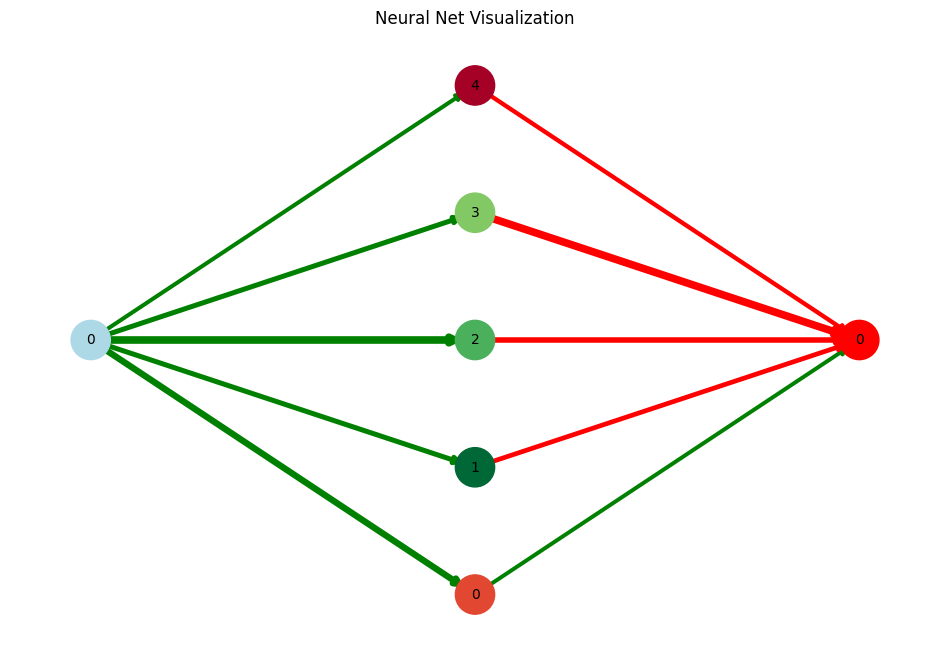

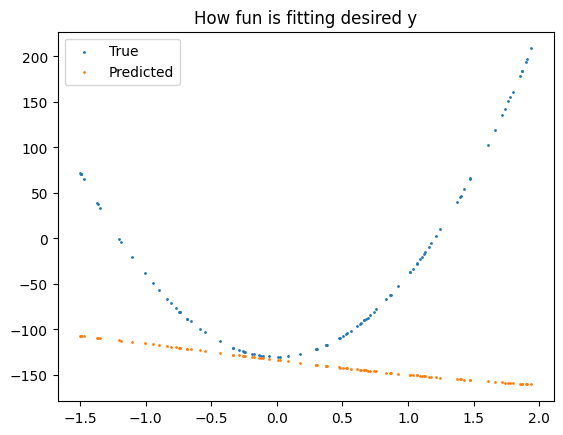

Epoch: 21, Loss (standarized): 0.8158543154551158
Epoch: 41, Loss (standarized): 0.6873951802841934
Epoch: 61, Loss (standarized): 0.5524564960158233
Epoch: 81, Loss (standarized): 0.422360706001902
Epoch: 101, Loss (standarized): 0.3100878203125264


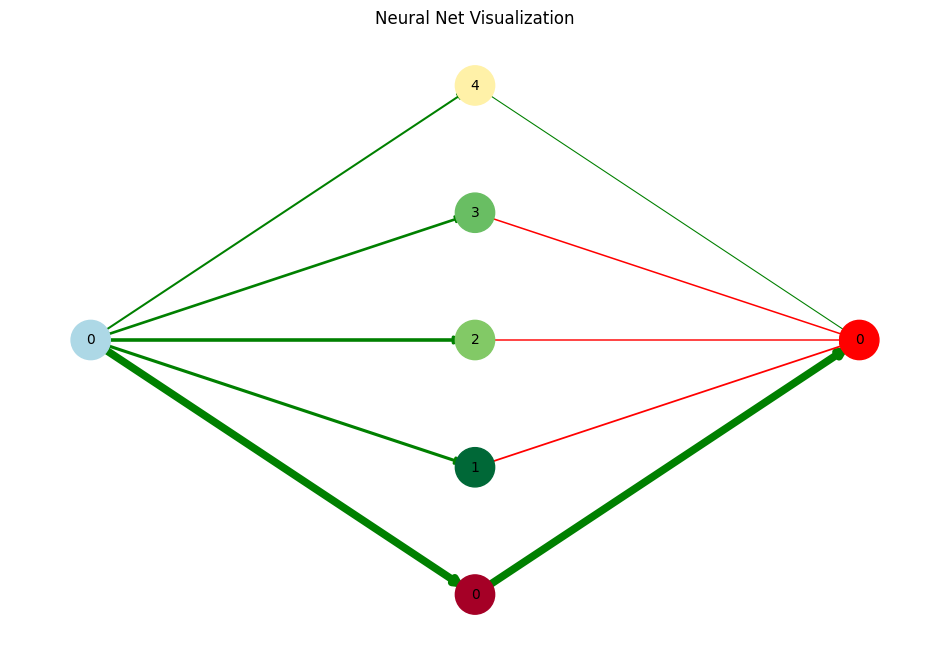

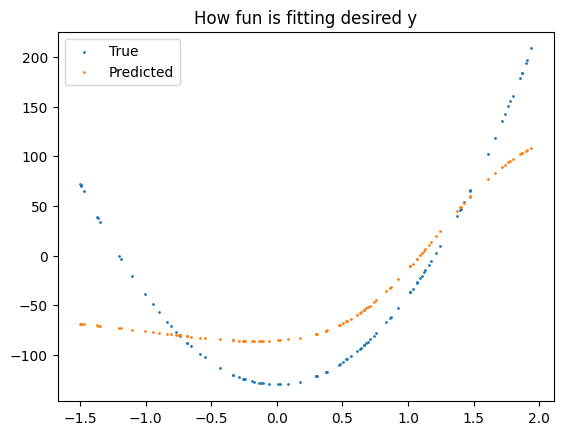

Epoch: 121, Loss (standarized): 0.22083567594189124
Epoch: 141, Loss (standarized): 0.15810596650016878
Epoch: 161, Loss (standarized): 0.11959176493497142
Epoch: 181, Loss (standarized): 0.09788198814134891
Epoch: 201, Loss (standarized): 0.08563378064623245


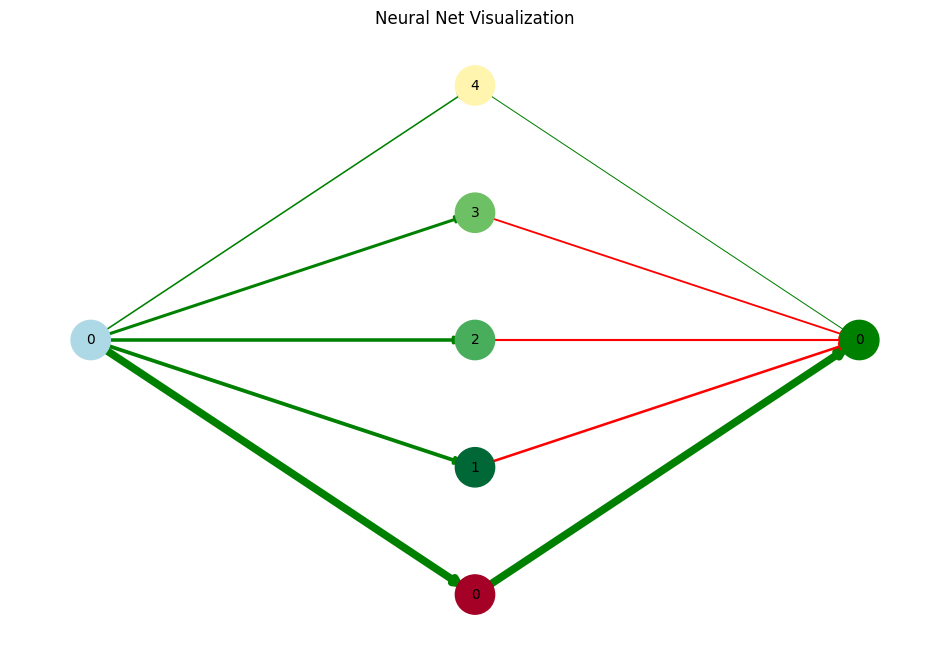

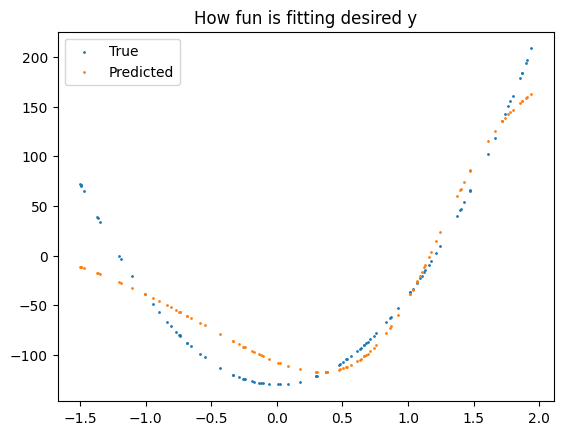

Epoch: 221, Loss (standarized): 0.07803736865531707
Epoch: 241, Loss (standarized): 0.0725835414610844
Epoch: 261, Loss (standarized): 0.06813343936154367
Epoch: 281, Loss (standarized): 0.06421026117811841
Epoch: 301, Loss (standarized): 0.06061895232499947


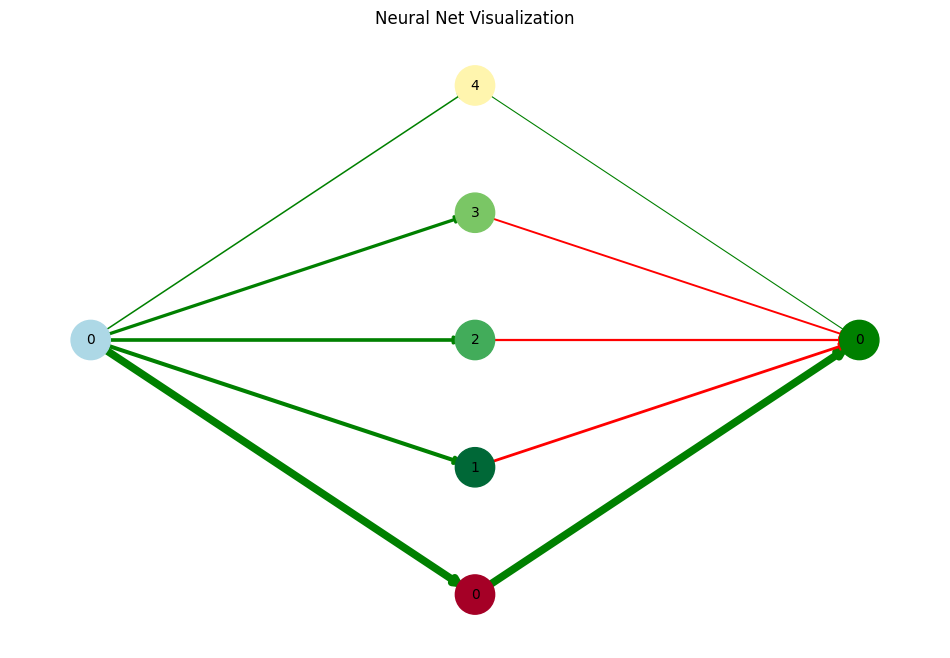

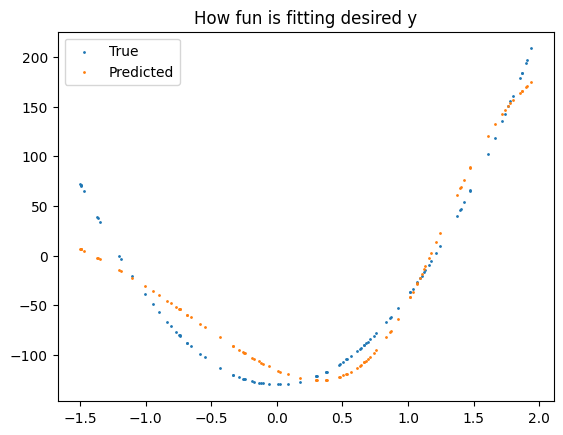

Epoch: 321, Loss (standarized): 0.05727555561277617
Epoch: 341, Loss (standarized): 0.054138841971692456
Epoch: 361, Loss (standarized): 0.05118477223409454
Epoch: 381, Loss (standarized): 0.04839713169302098
Final epoch: 400, Final loss (standarized): 0.045892028624003156


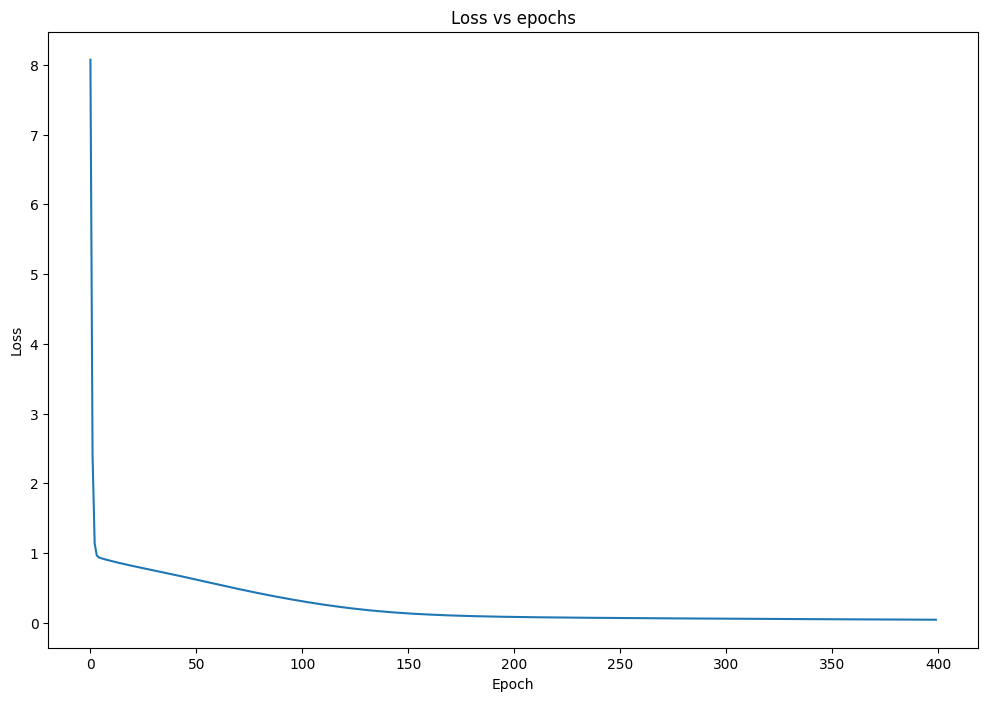

In [9]:
# Używając batch gradient descent
net = MLP([1, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train_visualize(x = x_train, y = y_train, epochs = 400, lr = 0.5)

Epoch: 1, Loss (standarized): 1.7212072942510361


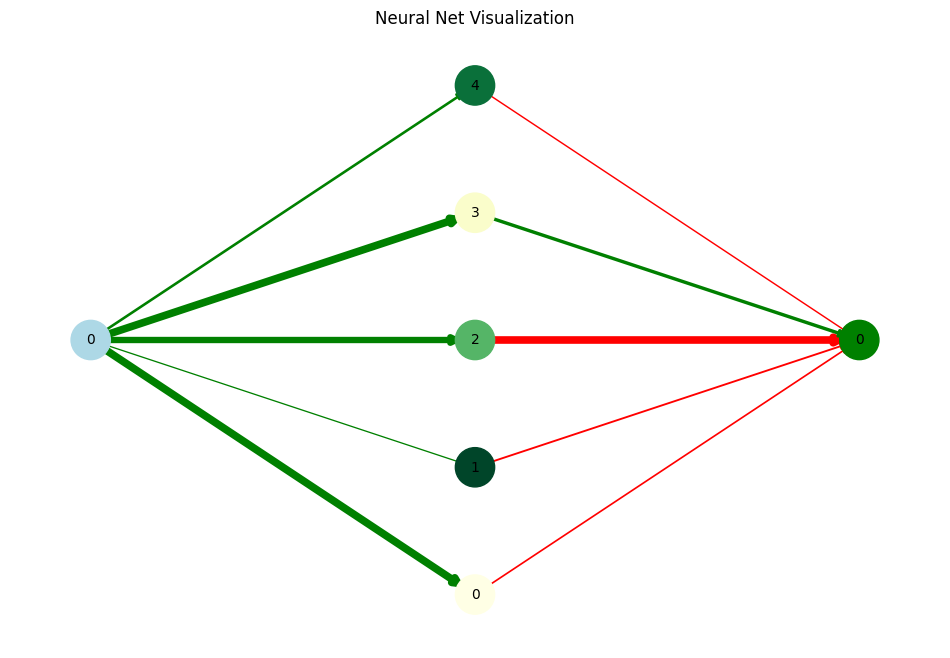

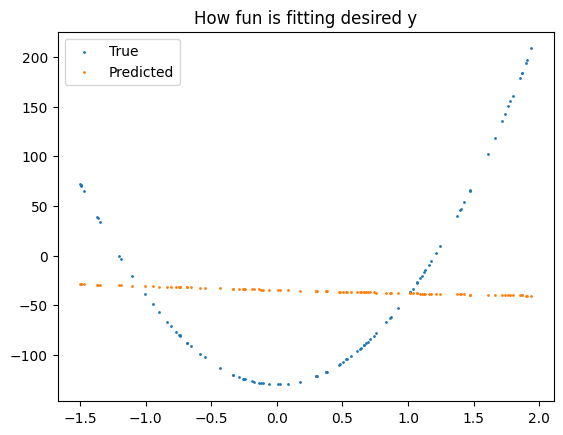

Epoch: 21, Loss (standarized): 0.6283208564090714
Epoch: 41, Loss (standarized): 0.30453842609878295
Epoch: 61, Loss (standarized): 0.08651326883340957
Epoch: 81, Loss (standarized): 0.051306286871641515
Epoch: 101, Loss (standarized): 0.03353436613666538


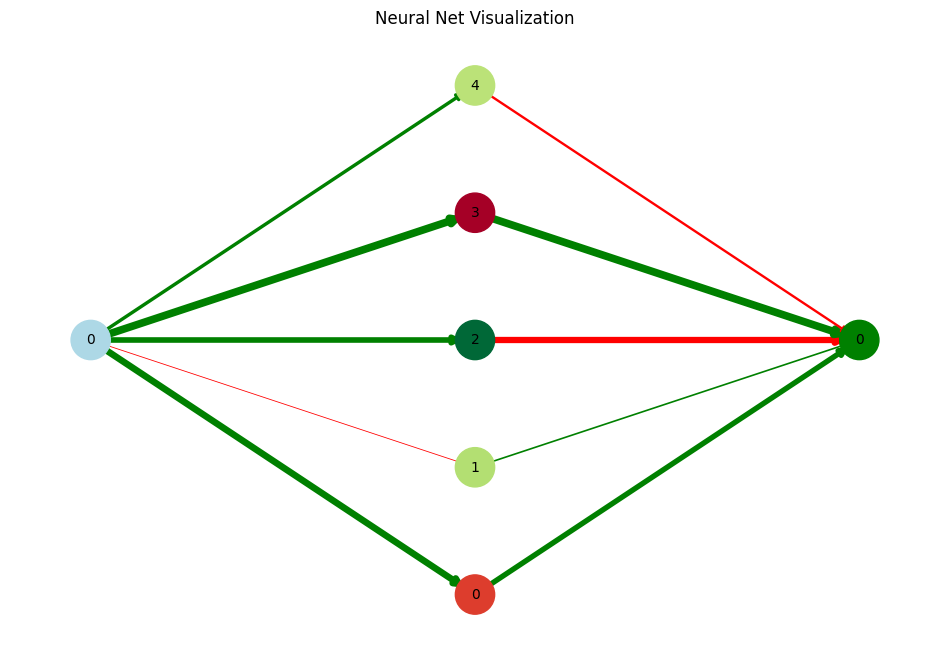

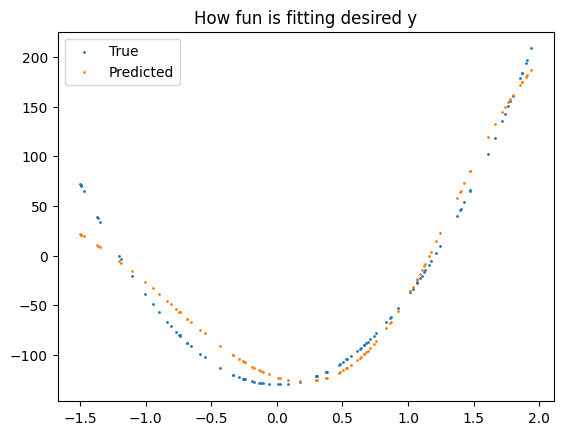

Epoch: 121, Loss (standarized): 0.026200074120290497
Epoch: 141, Loss (standarized): 0.020014859051811384
Epoch: 161, Loss (standarized): 0.01640546797288732
Epoch: 181, Loss (standarized): 0.015215455749967322
Epoch: 201, Loss (standarized): 0.010439197833735075


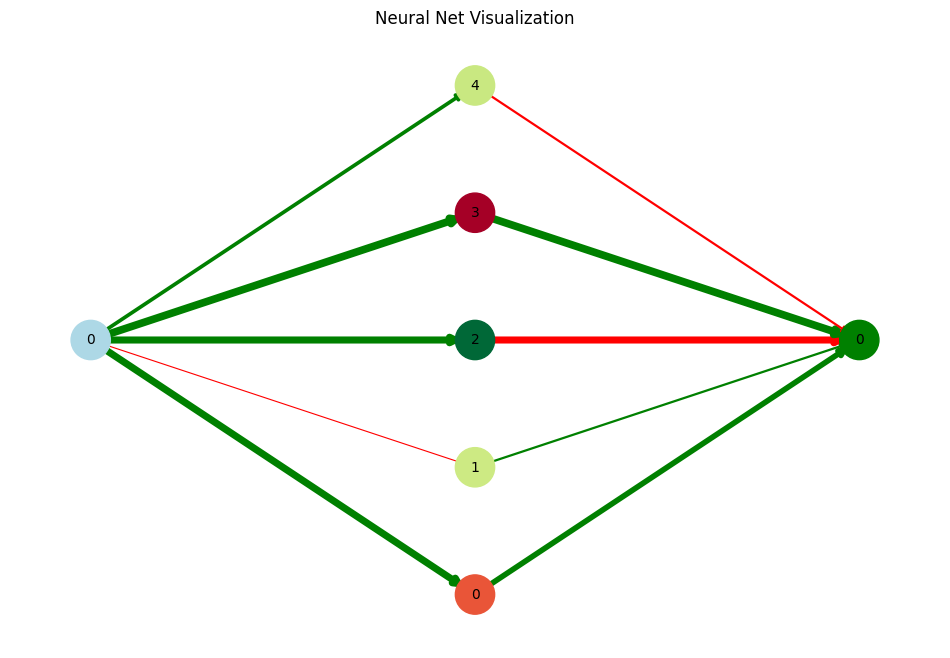

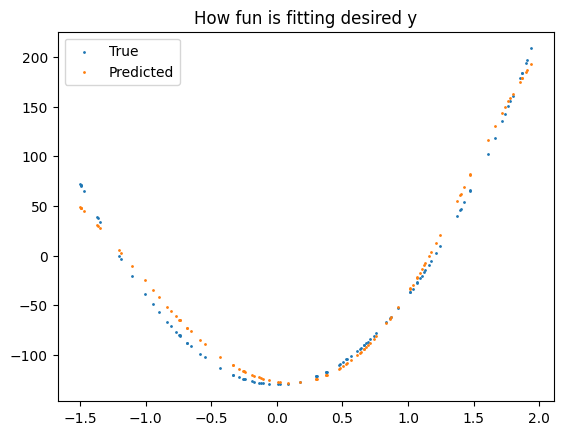

Epoch: 221, Loss (standarized): 0.008753826308878903
Epoch: 241, Loss (standarized): 0.006827409966409294
Epoch: 261, Loss (standarized): 0.005661237472462909
Epoch: 281, Loss (standarized): 0.004888798937899449
Epoch: 301, Loss (standarized): 0.004239255086348362


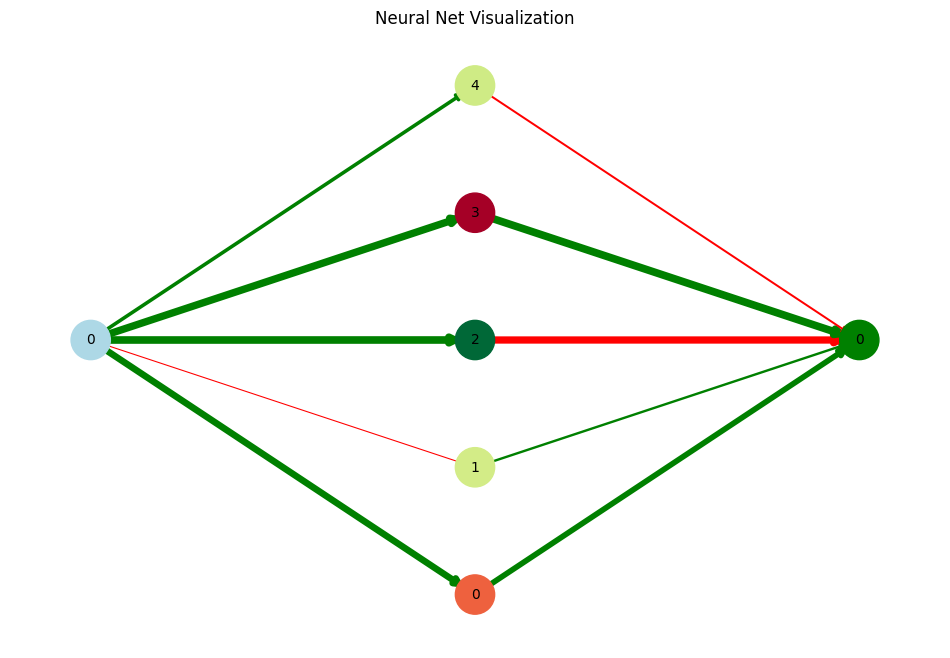

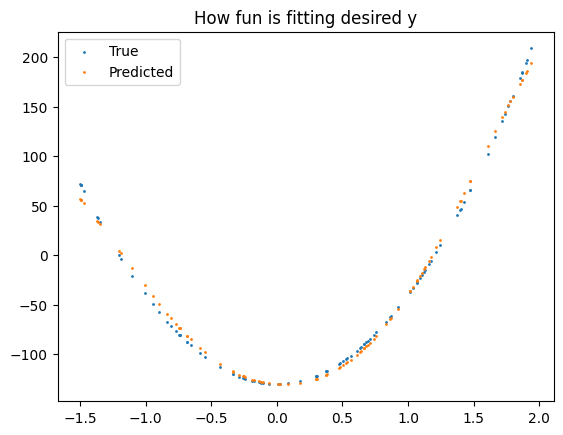

Epoch: 321, Loss (standarized): 0.0036247134176091247
Epoch: 341, Loss (standarized): 0.003004865529492735
Epoch: 361, Loss (standarized): 0.0030086584090330175
Epoch: 381, Loss (standarized): 0.002540797868299366
Final epoch: 400, Final loss (standarized): 0.0020134636454859425


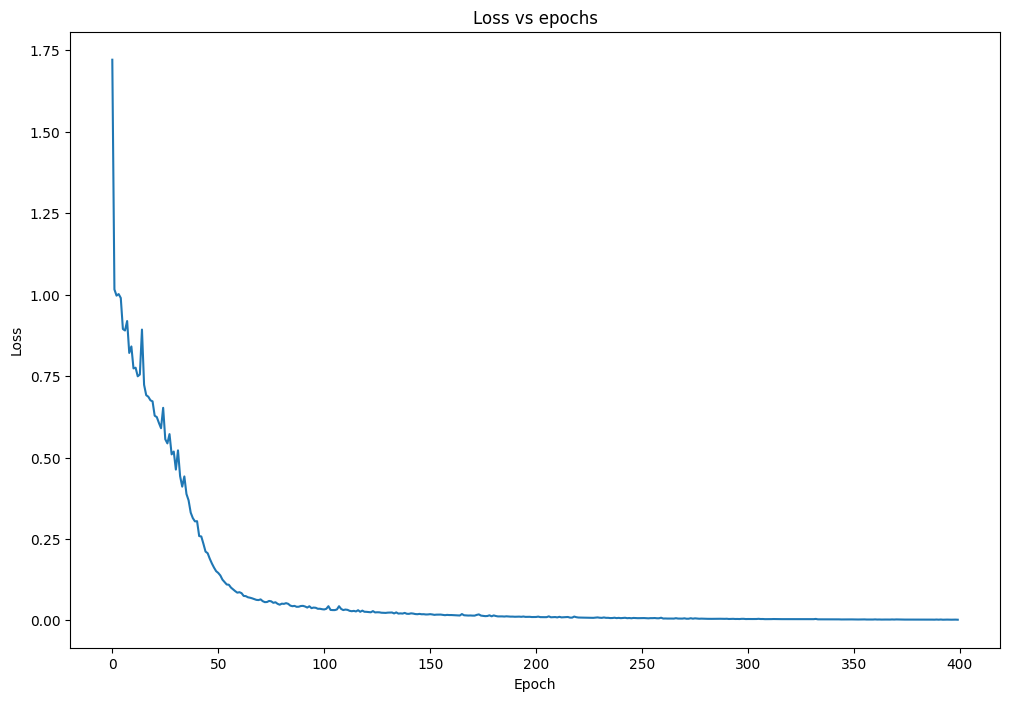

In [10]:
# Używając mini-batch z 32 batch_size
net = MLP([1, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train_visualize(x = x_train, y = y_train, epochs = 400, lr = 0.5, batch_size=32)

Można zauważyć, że mini-batch szybciej (w sensie ilości epok) zbiega do funkcji. <br>
Dobra to sprawdźmy czy spełniliśmy wymagania odnośnie mse

In [11]:
net = MLP([1, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 0.4, batch_size=32)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")

Epoch: 1, Loss (standarized): 1.882096403067842
Epoch: 501, Loss (standarized): 0.001940616467464842
Epoch: 1001, Loss (standarized): 0.0004822934379921634
Epoch: 1501, Loss (standarized): 0.00034679722195584176
Epoch: 2001, Loss (standarized): 0.0003532701592403526
Epoch: 2501, Loss (standarized): 0.00023351070899071328
Epoch: 3001, Loss (standarized): 0.00018630291071997302
Epoch: 3501, Loss (standarized): 0.00015479446749363065
Epoch: 4001, Loss (standarized): 0.00013704436947581378
Epoch: 4501, Loss (standarized): 0.00012122834239839395
Epoch: 5001, Loss (standarized): 9.809163621470361e-05
Epoch: 5501, Loss (standarized): 0.00010441737318897653
Epoch: 6001, Loss (standarized): 7.288269903443087e-05
Epoch: 6501, Loss (standarized): 6.499729645501925e-05
Epoch: 7001, Loss (standarized): 6.012342205499814e-05
Epoch: 7501, Loss (standarized): 5.369772002942307e-05
Epoch: 8001, Loss (standarized): 4.83983356695668e-05
Epoch: 8501, Loss (standarized): 4.66379526410676e-05
Epoch: 9001, L

Super!

### Dane: steps-small

In [12]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/steps-small-training.csv", index_col = 0).to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/steps-small-test.csv", index_col = 0).to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

Epoch: 1, Loss (standarized): 4.85321156621832


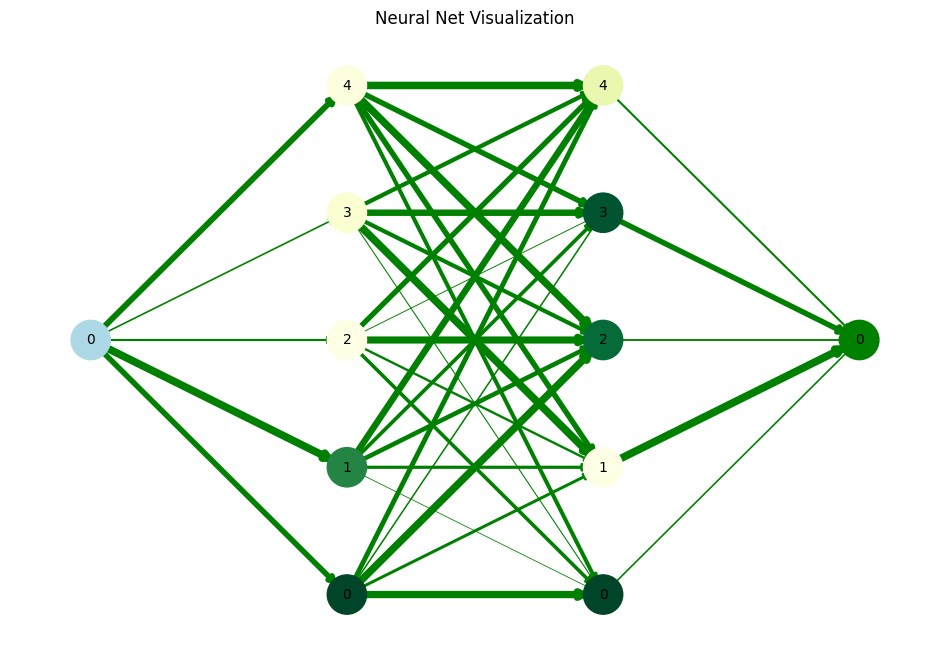

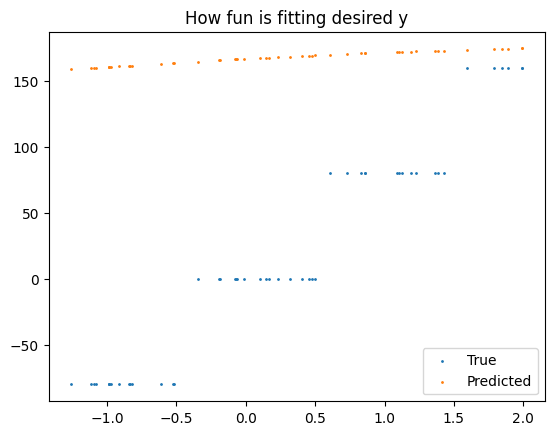

Epoch: 501, Loss (standarized): 0.9452552362785138
Epoch: 1001, Loss (standarized): 0.9000334461104209
Epoch: 1501, Loss (standarized): 0.8247065531115001
Epoch: 2001, Loss (standarized): 0.7006275402614613
Epoch: 2501, Loss (standarized): 0.5224089632206078


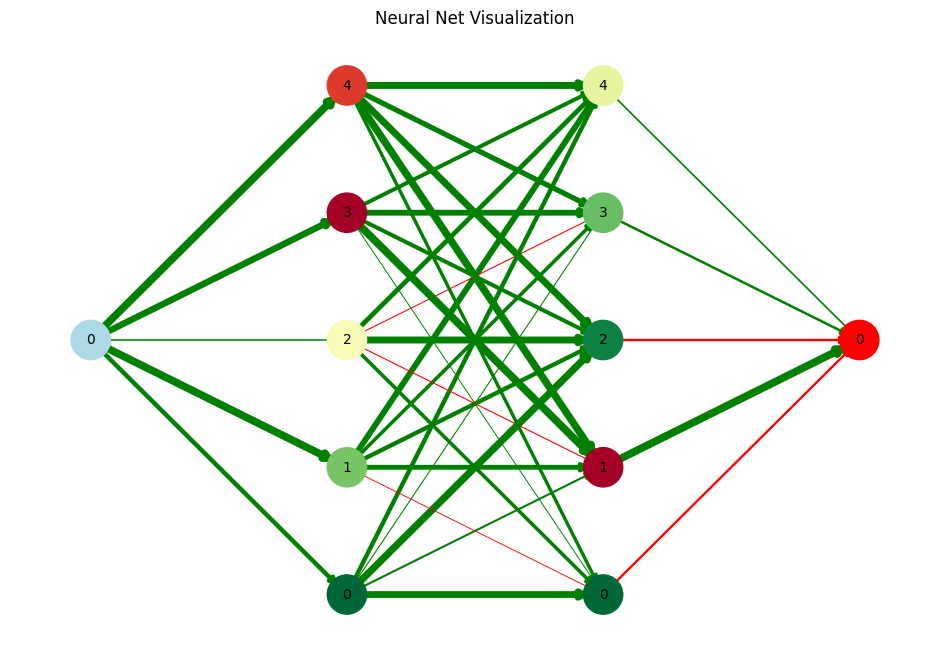

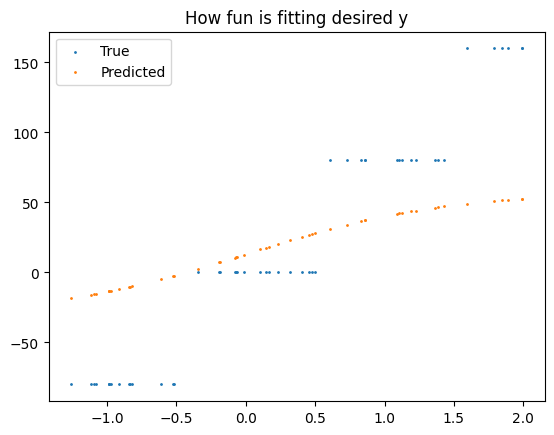

Epoch: 3001, Loss (standarized): 0.33241881827582637
Epoch: 3501, Loss (standarized): 0.1964387239221302
Epoch: 4001, Loss (standarized): 0.12876578625587692
Epoch: 4501, Loss (standarized): 0.10190589278289847
Epoch: 5001, Loss (standarized): 0.09167739545630454


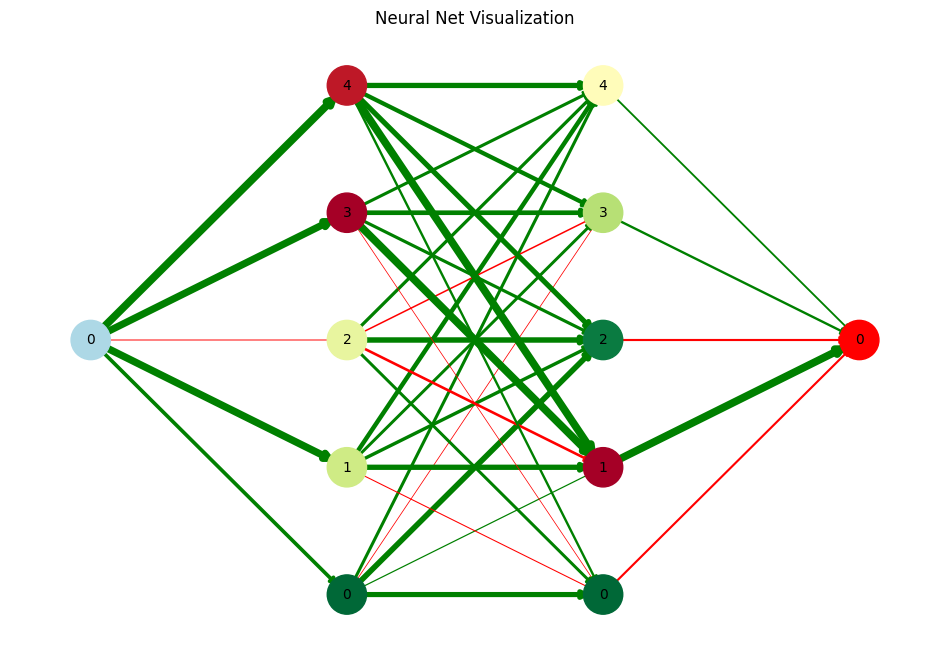

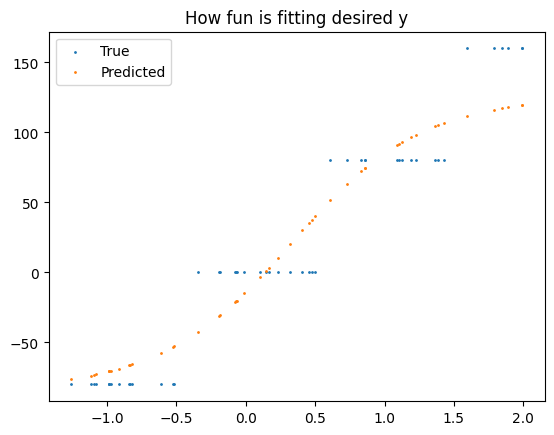

Epoch: 5501, Loss (standarized): 0.08713712107393025
Epoch: 6001, Loss (standarized): 0.08454501232159277
Epoch: 6501, Loss (standarized): 0.08273844546464726
Epoch: 7001, Loss (standarized): 0.08132933692057186
Epoch: 7501, Loss (standarized): 0.0801582439048043


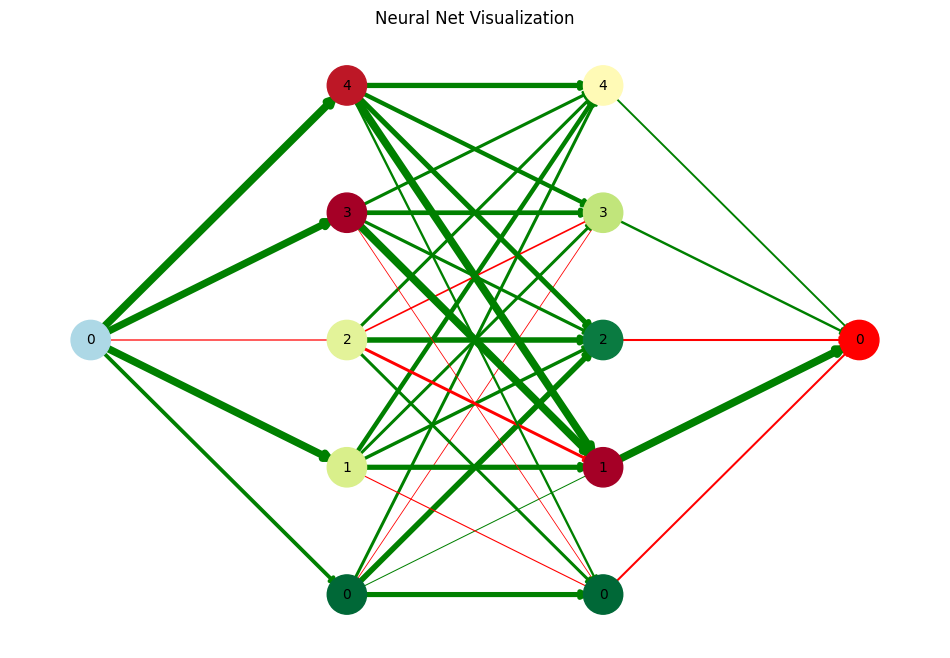

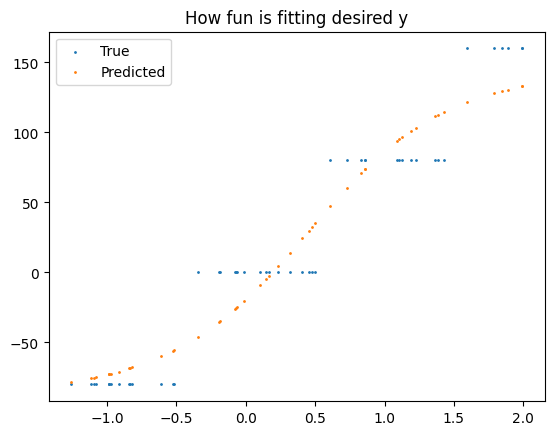

Epoch: 8001, Loss (standarized): 0.07914384663242006
Epoch: 8501, Loss (standarized): 0.07823889159793837
Epoch: 9001, Loss (standarized): 0.07741415545921462
Epoch: 9501, Loss (standarized): 0.07665094098967117
Final epoch: 10000, Final loss (standarized): 0.07593835971563473


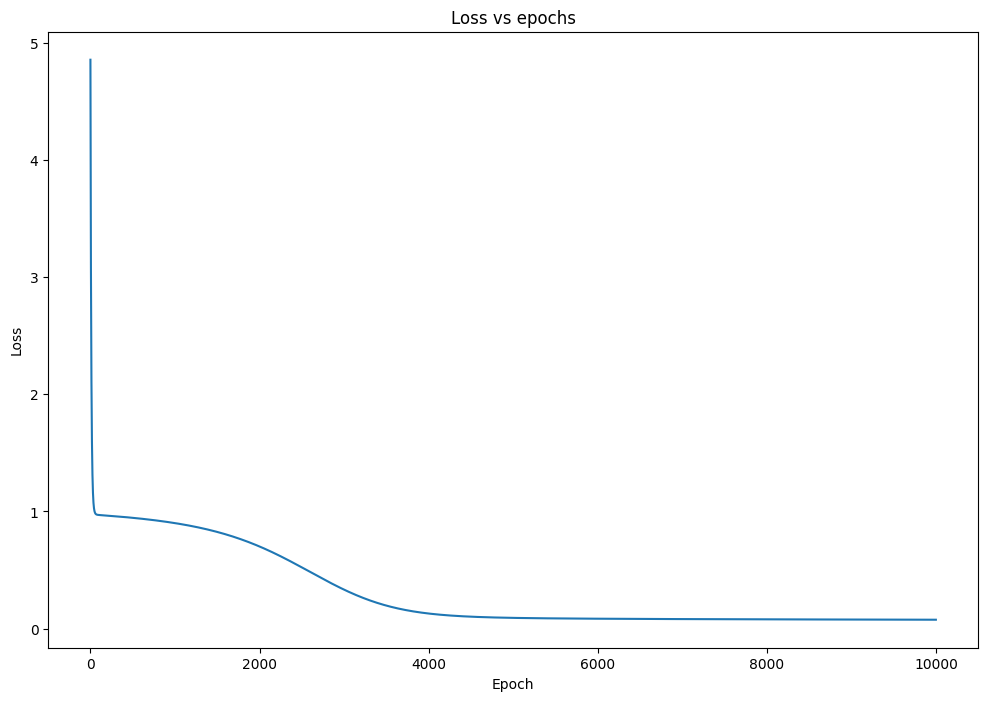

In [13]:
net = MLP([1, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train_visualize(x = x_train, y = y_train, epochs = 10000, lr = 0.01)

Nie wygląda to najlepiej

Epoch: 1, Loss (standarized): 2.7374244852927956
Epoch: 501, Loss (standarized): 0.9983886876684852
Epoch: 1001, Loss (standarized): 0.08296563316733503
Epoch: 1501, Loss (standarized): 0.07082894325619438
Epoch: 2001, Loss (standarized): 0.06479436857747405
Epoch: 2501, Loss (standarized): 0.06656665716298393
Epoch: 3001, Loss (standarized): 0.059270298124623734
Epoch: 3501, Loss (standarized): 0.06065149826919023
Epoch: 4001, Loss (standarized): 0.07272577906112258
Epoch: 4501, Loss (standarized): 0.05983678268029726
Epoch: 5001, Loss (standarized): 0.06761464007814251
Epoch: 5501, Loss (standarized): 0.06453311658219088
Epoch: 6001, Loss (standarized): 0.059850981534758575
Epoch: 6501, Loss (standarized): 0.06051599540856708
Epoch: 7001, Loss (standarized): 0.062003567880476215
Epoch: 7501, Loss (standarized): 0.06419410520459842
Epoch: 8001, Loss (standarized): 0.06061993612294129
Epoch: 8501, Loss (standarized): 0.06501387747884517
Epoch: 9001, Loss (standarized): 0.06249404690564

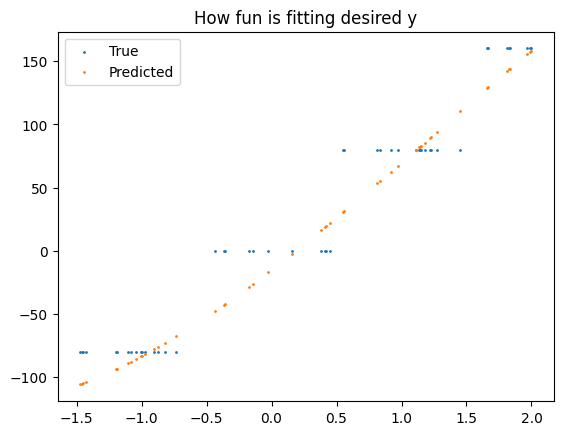

In [14]:
# LR = 0.05
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 0.05, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
eval_2d(net, x_test, y_test)

Epoch: 1, Loss (standarized): 2.052105311893673
Epoch: 501, Loss (standarized): 0.07018099788638815
Epoch: 1001, Loss (standarized): 0.06428449586914417
Epoch: 1501, Loss (standarized): 0.061080931558062046
Epoch: 2001, Loss (standarized): 0.06297484922352034
Epoch: 2501, Loss (standarized): 0.05575348273327523
Epoch: 3001, Loss (standarized): 0.05689685531227081
Epoch: 3501, Loss (standarized): 0.05523566579129201
Epoch: 4001, Loss (standarized): 0.05774855621851803
Epoch: 4501, Loss (standarized): 0.05562311084386216
Epoch: 5001, Loss (standarized): 0.05398823373426032
Epoch: 5501, Loss (standarized): 0.05413630738637864
Epoch: 6001, Loss (standarized): 0.05231782673955481
Epoch: 6501, Loss (standarized): 0.052067713249793056
Epoch: 7001, Loss (standarized): 0.04834341961971768
Epoch: 7501, Loss (standarized): 0.04766944561154483
Epoch: 8001, Loss (standarized): 0.04669250297835394
Epoch: 8501, Loss (standarized): 0.044557224428689875
Epoch: 9001, Loss (standarized): 0.03736249708765

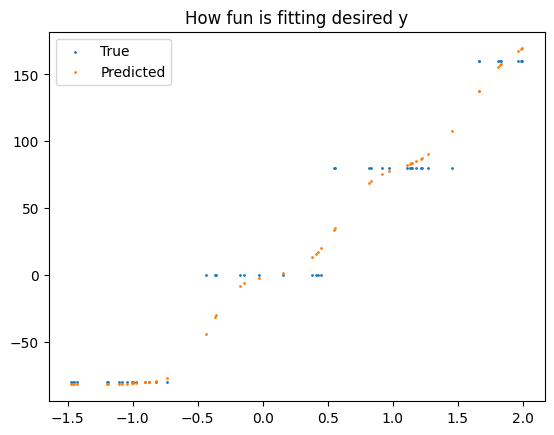

In [15]:
# lr = 0.1
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 0.2, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
eval_2d(net, x_test, y_test)

Wydaję się działać, jednak więcej epok potrzeba

Epoch: 1, Loss (standarized): 2.3922088601079863
Epoch: 501, Loss (standarized): 0.1471197572082298
Epoch: 1001, Loss (standarized): 0.06844620074556808
Epoch: 1501, Loss (standarized): 0.06507134027140402
Epoch: 2001, Loss (standarized): 0.06096140602992165
Epoch: 2501, Loss (standarized): 0.05648976582415282
Epoch: 3001, Loss (standarized): 0.05430336206756679
Epoch: 3501, Loss (standarized): 0.05186600360815653
Epoch: 4001, Loss (standarized): 0.049372187403095916
Epoch: 4501, Loss (standarized): 0.05003244262591091
Epoch: 5001, Loss (standarized): 0.04410107071605972
Epoch: 5501, Loss (standarized): 0.03749049343330459
Epoch: 6001, Loss (standarized): 0.032610860165853864
Epoch: 6501, Loss (standarized): 0.024232679522616797
Epoch: 7001, Loss (standarized): 0.02062201662740683
Epoch: 7501, Loss (standarized): 0.01488365498792658
Epoch: 8001, Loss (standarized): 0.01278106851189184
Epoch: 8501, Loss (standarized): 0.012383324748301183
Epoch: 9001, Loss (standarized): 0.0117685124503

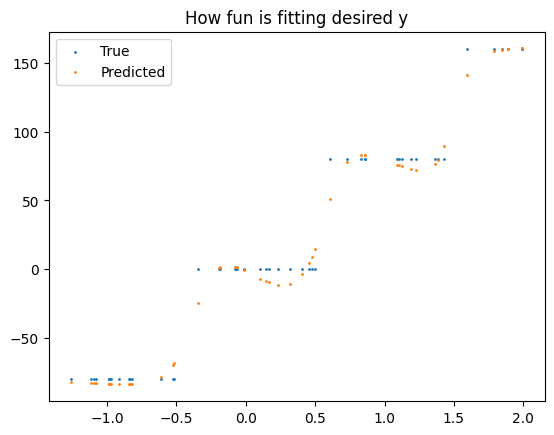


DLA ZBIORU TESTOWEGO


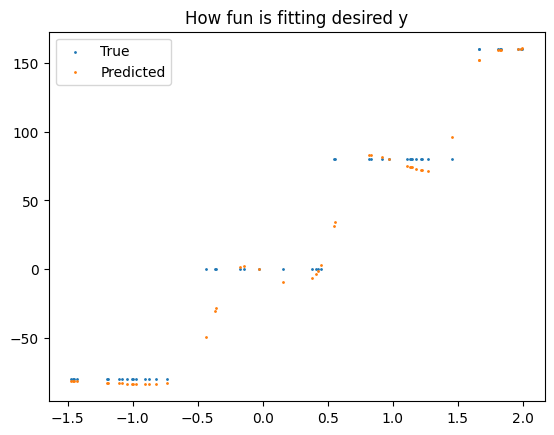


JAK WG SIECI WYGLĄDA FUNKCJA


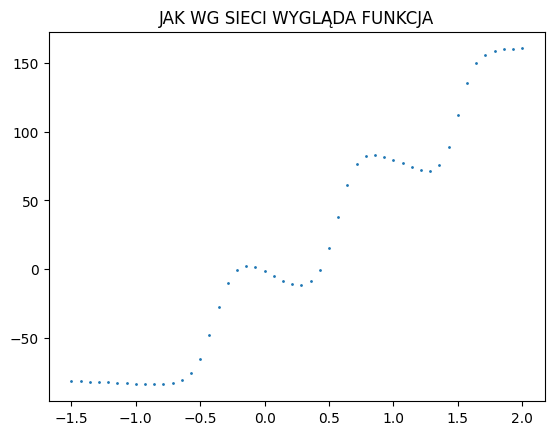

In [16]:
# lr = 0.3
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 0.3, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.show()

Działa lepiej jeszcze trochę

Epoch: 1, Loss (standarized): 9.301362799007336
Epoch: 501, Loss (standarized): 0.08627962503429508
Epoch: 1001, Loss (standarized): 0.05969704675721612
Epoch: 1501, Loss (standarized): 0.057903283111309496
Epoch: 2001, Loss (standarized): 0.058190077715473916
Epoch: 2501, Loss (standarized): 0.05768100138959862
Epoch: 3001, Loss (standarized): 0.04792455501509773
Epoch: 3501, Loss (standarized): 0.03841429994486466
Epoch: 4001, Loss (standarized): 0.028396590698182768
Epoch: 4501, Loss (standarized): 0.019628269766864246
Epoch: 5001, Loss (standarized): 0.015017273882022371
Epoch: 5501, Loss (standarized): 0.010265097243750068
Epoch: 6001, Loss (standarized): 0.007291891155860505
Epoch: 6501, Loss (standarized): 0.005058133439832205
Epoch: 7001, Loss (standarized): 0.0036013898900036103
Epoch: 7501, Loss (standarized): 0.0030145135607203602
Epoch: 8001, Loss (standarized): 0.0023208417734598974
Epoch: 8501, Loss (standarized): 0.0017437149988600022
Epoch: 9001, Loss (standarized): 0.0

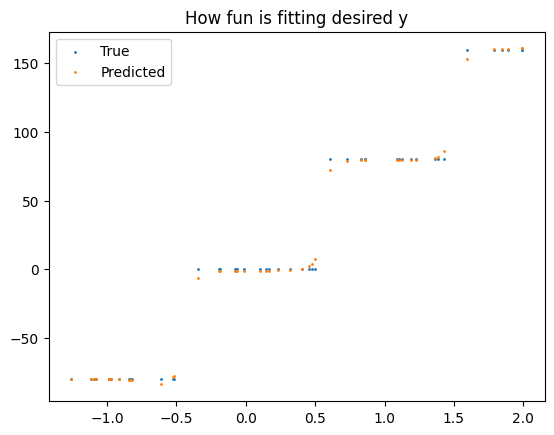


DLA ZBIORU TESTOWEGO


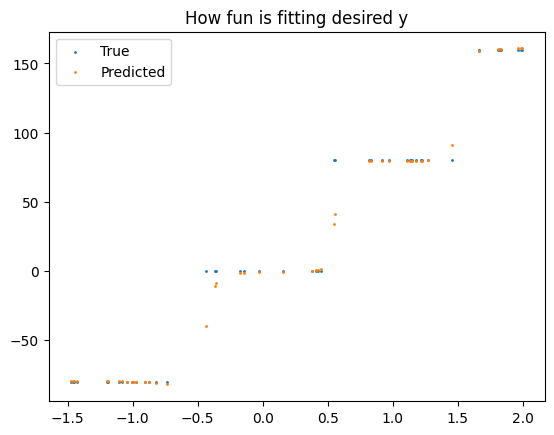


JAK WG SIECI WYGLĄDA FUNKCJA


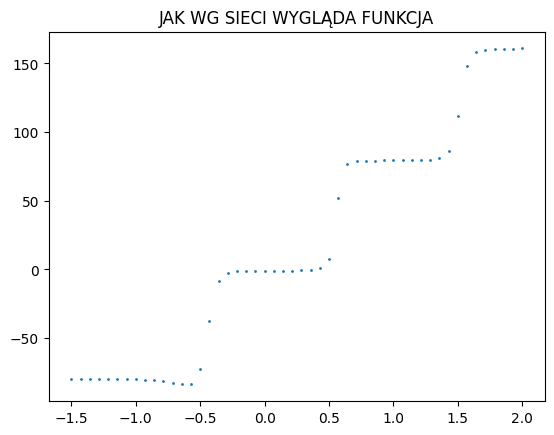

In [17]:
# lr = 0.5
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 0.5, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.show()

Epoch: 1, Loss (standarized): 47.92934476460492
Epoch: 501, Loss (standarized): 0.09149362285641012
Epoch: 1001, Loss (standarized): 0.06239142750516087
Epoch: 1501, Loss (standarized): 0.06603806724474595
Epoch: 2001, Loss (standarized): 0.08692533487126944
Epoch: 2501, Loss (standarized): 0.06315448102955444
Epoch: 3001, Loss (standarized): 0.08572029698190188
Epoch: 3501, Loss (standarized): 0.03564381359746283
Epoch: 4001, Loss (standarized): 0.017847619617629578
Epoch: 4501, Loss (standarized): 0.023649919472145464
Epoch: 5001, Loss (standarized): 0.016402616789609366
Epoch: 5501, Loss (standarized): 0.009350230654134336
Epoch: 6001, Loss (standarized): 0.016040972191627405
Epoch: 6501, Loss (standarized): 0.00771218128031204
Epoch: 7001, Loss (standarized): 0.00712968336855519
Epoch: 7501, Loss (standarized): 0.007697257834145774
Epoch: 8001, Loss (standarized): 0.007092227307588376
Epoch: 8501, Loss (standarized): 0.005451590496366942
Epoch: 9001, Loss (standarized): 0.006149608

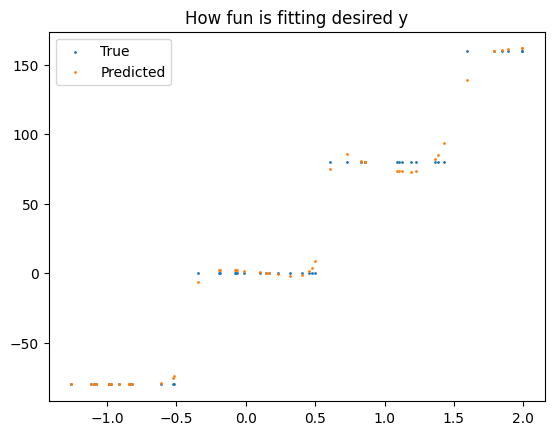


DLA ZBIORU TESTOWEGO


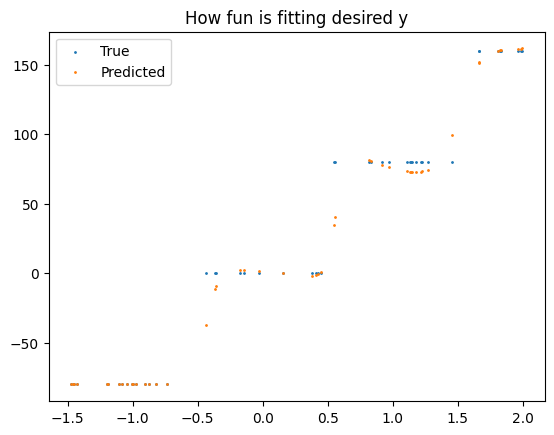


JAK WG SIECI WYGLĄDA FUNKCJA


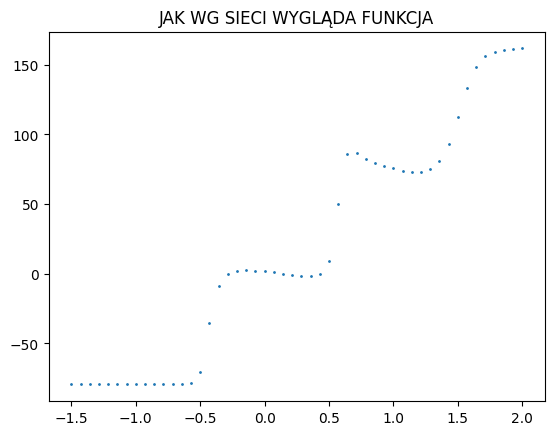

In [18]:
# lr = 1
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 10000, lr = 1, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.show()

Dobra to spróbujmy więcej epok na lr=0.5

Epoch: 1, Loss (standarized): 11.498105836470966
Epoch: 5001, Loss (standarized): 0.01930190263019655
Epoch: 10001, Loss (standarized): 0.0014104432699874512
Epoch: 15001, Loss (standarized): 0.00046786605648050435
Epoch: 20001, Loss (standarized): 0.0002516165001272495
Epoch: 25001, Loss (standarized): 0.00017401474137275147
Epoch: 30001, Loss (standarized): 0.0001259329857427179
Epoch: 35001, Loss (standarized): 8.523355282779116e-05
Epoch: 40001, Loss (standarized): 5.7252107255627455e-05
Epoch: 45001, Loss (standarized): 3.783476015185941e-05
Epoch: 50001, Loss (standarized): 2.285943242947197e-05
Epoch: 55001, Loss (standarized): 2.1999538003073976e-05
Epoch: 60001, Loss (standarized): 1.8461265556814387e-05
Epoch: 65001, Loss (standarized): 1.7087097547056472e-05
Epoch: 70001, Loss (standarized): 1.3449274947537073e-05
Epoch: 75001, Loss (standarized): 1.1809723864094618e-05
Epoch: 80001, Loss (standarized): 1.0707335329848532e-05
Epoch: 85001, Loss (standarized): 9.5209352106959

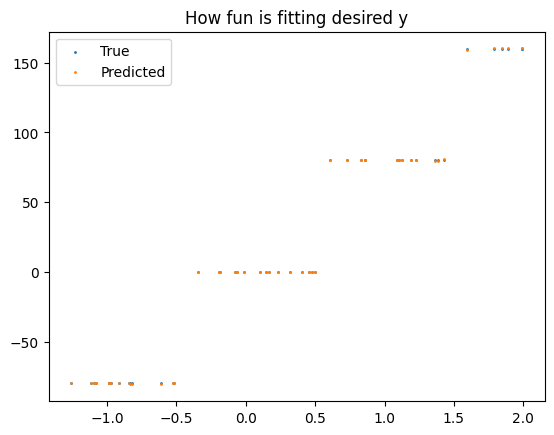


DLA ZBIORU TESTOWEGO


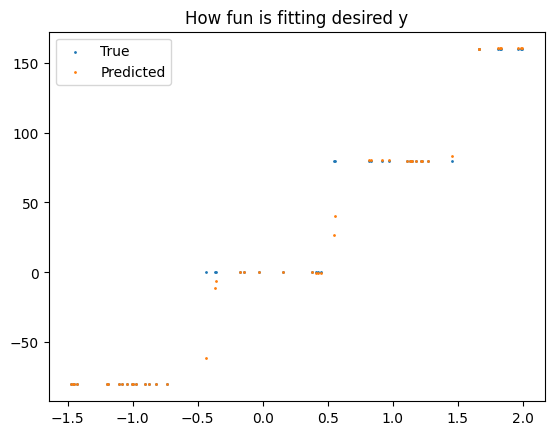


JAK WG SIECI WYGLĄDA FUNKCJA


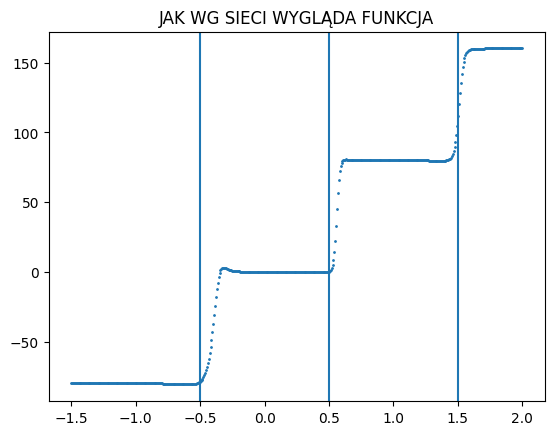

In [19]:
# lr = 0.5
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 100000, lr = 0.5, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2, num = 500).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.axvline(-0.5)
plt.axvline(0.5)
plt.axvline(1.5)
plt.show()

Epoch: 1, Loss (standarized): 2.2967583623403063
Epoch: 1501, Loss (standarized): 0.07913350937018282
Epoch: 3001, Loss (standarized): 0.03230405460163511
Epoch: 4501, Loss (standarized): 0.014479810539993013
Epoch: 6001, Loss (standarized): 0.011484239744844681
Epoch: 7501, Loss (standarized): 0.008215877579414426
Epoch: 9001, Loss (standarized): 0.005860547151689726
Epoch: 10501, Loss (standarized): 0.004122687177663032
Epoch: 12001, Loss (standarized): 0.003954468733300023
Epoch: 13501, Loss (standarized): 0.0027043520710826646
Epoch: 15001, Loss (standarized): 0.002385847903071028
Epoch: 16501, Loss (standarized): 0.0016315520555368016
Epoch: 18001, Loss (standarized): 0.0013679631036709577
Epoch: 19501, Loss (standarized): 0.0012639399526900527
Epoch: 21001, Loss (standarized): 0.0009168451648439647
Epoch: 22501, Loss (standarized): 0.0007519214869247022
Epoch: 24001, Loss (standarized): 0.0006834944268221937
Epoch: 25501, Loss (standarized): 0.0005390767447231509
Epoch: 27001, Lo

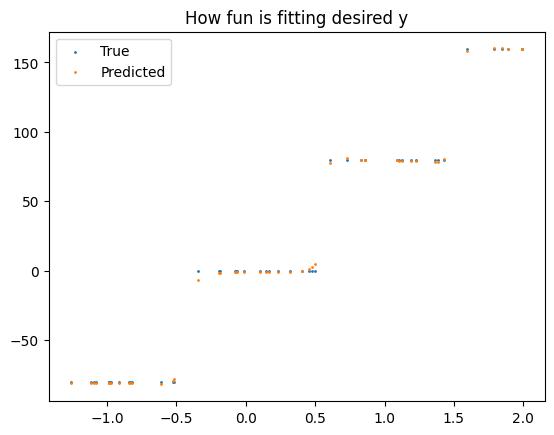


DLA ZBIORU TESTOWEGO


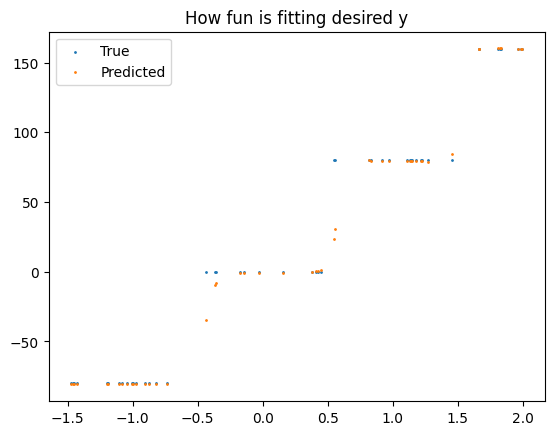


JAK WG SIECI WYGLĄDA FUNKCJA


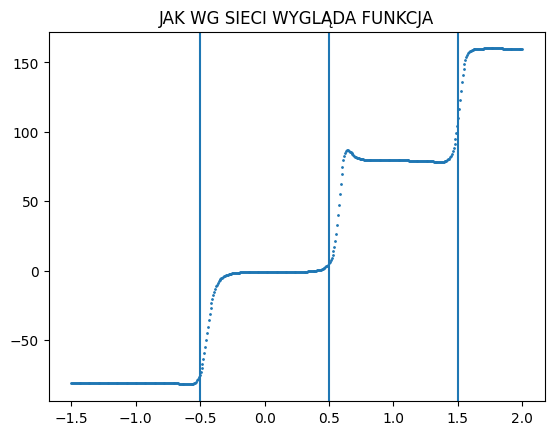

In [20]:
# lr = 0.5
net = MLP([1, 3, 5, 5, 3, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 30000, lr = 0.5, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2, num = 500).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.axvline(-0.5)
plt.axvline(0.5)
plt.axvline(1.5)
plt.show()

### Dane multimodal-large

In [31]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/multimodal-large-training.csv").to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/multimodal-large-test.csv").to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

Epoch: 1, Loss (standarized): 1.0639791142918327
Epoch: 21, Loss (standarized): 0.184840720317176
Epoch: 41, Loss (standarized): 0.17691142202002583
Epoch: 61, Loss (standarized): 0.08908727758492357
Epoch: 81, Loss (standarized): 0.024689278506032298
Epoch: 101, Loss (standarized): 0.020039155446039736
Epoch: 121, Loss (standarized): 0.013383439051574672
Epoch: 141, Loss (standarized): 0.0034205236885361083
Epoch: 161, Loss (standarized): 0.0018655909658241842
Epoch: 181, Loss (standarized): 0.0016714717446421755
Epoch: 201, Loss (standarized): 0.001593074954412819
Epoch: 221, Loss (standarized): 0.0015451070998437765
Epoch: 241, Loss (standarized): 0.0015003261075642203
Epoch: 261, Loss (standarized): 0.0014761304535923598
Epoch: 281, Loss (standarized): 0.001462348039912461
Epoch: 301, Loss (standarized): 0.001455151580643189
Epoch: 321, Loss (standarized): 0.001442812188111261
Epoch: 341, Loss (standarized): 0.0014304825936485308
Epoch: 361, Loss (standarized): 0.001432534247536453

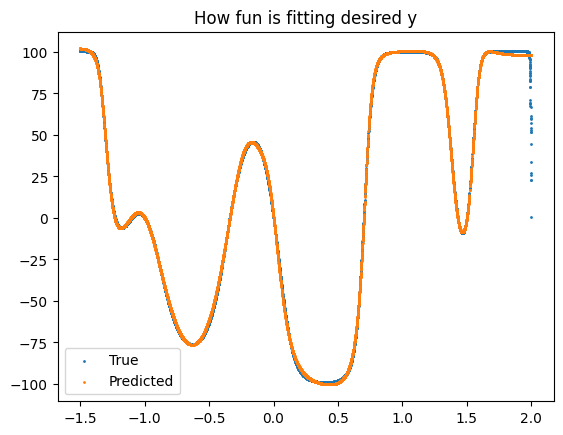


DLA ZBIORU TESTOWEGO


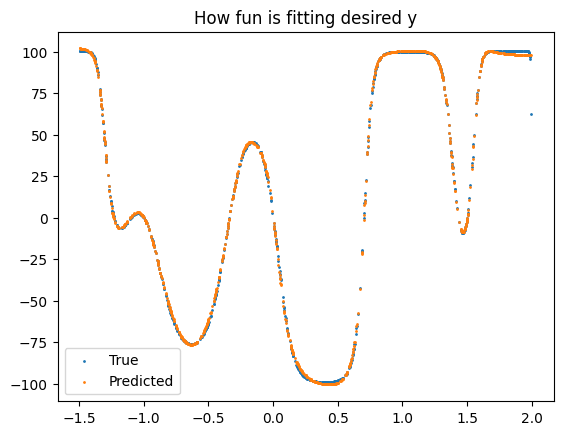


JAK WG SIECI WYGLĄDA FUNKCJA


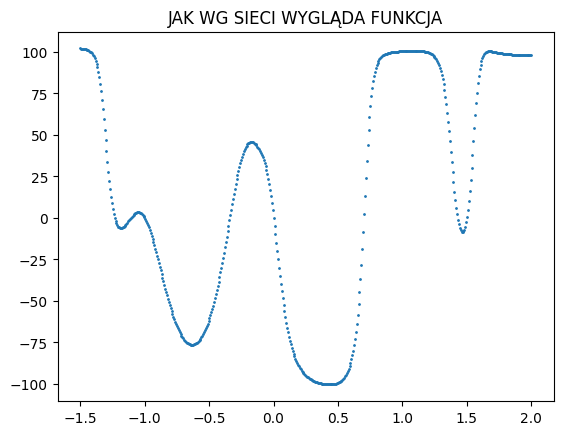

In [38]:
# lr = 0.4
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv)
net.train(x = x_train, y = y_train, epochs = 400, lr = 0.4, batch_size=8)
y_pred = net.predict(x_test)
print(f"\nOstatecznie MSE wynosi: {mse(y_pred, y_test)}")
print("\nDLA ZBIORU TRENINGOWEGO")
eval_2d(net, x_train, y_train)
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
x = np.linspace(-1.5, 2, 500).reshape(-1, 1)
plt.scatter(x, net.predict(x), s = 1, label = "True")
plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
plt.show()

In [22]:
np.random.shuffle(np.arange(100))